In [1]:
import tensorflow as tf #type: ignore
import matplotlib as plt #type: ignore
import collections
import os
import time
import json
import random
import numpy as np #type: ignore
from tensorflow.keras.models import load_model
from tensorflow import keras
from PIL import Image #type: ignore

In [2]:
devices = tf.config.experimental.list_physical_devices("GPU")
for device in devices:
    tf.config.experimental.set_memory_growth(device, enable=True)

In [3]:
annotation_folder = "archive"
annotation_file = os.path.join(annotation_folder, "captions.txt")
image_folder = "archive/Images"

In [4]:
#preprocessing and saving
if not os.path.exists("captions.npy") or not os.path.exists("tokenizer.json"):
    # Read annotations
    with open(annotation_file, "r") as file:
        annotations = file.read()
        
    image_path_to_caption = collections.defaultdict(list)
    
    for line in annotations.split("\n"):
        if line.strip():
            image_name = line.split(",")[0]
            caption = line.split(",")[-1]
            caption = f"<start> {caption} <end>"
            image_path = os.path.join(image_folder, image_name)
            
            if image_path.endswith(".jpg"):
                image_path_to_caption[image_path].append(caption)
                
    train_image_paths = list(image_path_to_caption.keys())
    random.shuffle(train_image_paths)
    
    train_captions = []
    image_name_vector = []
    
    for image_path in train_image_paths:
        caption_list = image_path_to_caption[image_path]
        train_captions.extend(caption_list)
        image_name_vector.extend([image_path] * len(caption_list))
        
    top_k = 5000
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=top_k, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\\]^_`{|}~'
    )
    tokenizer.fit_on_texts(train_captions)
    train_seqs = tokenizer.texts_to_sequences(train_captions)
    cap_vector = tf.keras.preprocessing.sequence.pad_sequences(
        train_seqs, padding="post"
    )
    np.save("captions.npy", cap_vector)
    
    with open("tokenizer.json", "w") as f:
        f.write(tokenizer.to_json())
    
    if not os.path.exists("image_name_vector.npy"):
        np.save("image_name_vector.npy", image_name_vector)
    print("Preprocessing complete! Saved captions and image features.")

else:
    print("Loading preprocessed data...")
    # Load tokenized captions
    cap_vector = np.load("captions.npy")

    # Load tokenizer
    with open("tokenizer.json", "r") as f:
        tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(f.read())
    with open(annotation_file, "r") as file:
        annotations = file.read()

    image_name_vector = np.load("image_name_vector.npy", allow_pickle=True).tolist()
        
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(image_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)
    
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)
slice_index = int(len(img_keys) * 0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []

for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []

for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

Loading preprocessed data...


In [5]:
def load_image(image_path):
    # Load the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    # Resize the image while preserving the aspect ratio
    target_size = (299, 299)
    image = tf.image.resize_with_pad(image, target_size[0], target_size[1])

    # Preprocess the image for InceptionV3
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, image_path

In [6]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [7]:
encode_train = sorted(set(image_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image).batch(8)

In [8]:
# for img, path in tqdm(image_dataset):
#     batch_features = image_features_extract_model(img)
#     batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
#     for bf, p in zip(batch_features, path):
#         path_of_features = p.numpy().decode("utf-8")
#         np.save(path_of_features, bf.numpy())

In [9]:
batch_size = 8
buffer_size = 300
embedding_dim = 256
units = 512
top_k = 5000
vocab_size = top_k + 1
num_steps = len(img_name_train)
features_shape = 2048
attention_features_shape = 64

In [10]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [11]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [12]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(32360, 32360, 8095, 8095)

In [13]:
def map_func(image_name, cap):
    img_tensor = np.load(image_name.decode("utf-8") + ".npy")
    return img_tensor, cap

In [14]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]))
dataset = dataset.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
print("Dataset is ready for training.")

val_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]))
val_dataset = val_dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
print("Dataset is ready for validation.")

Dataset is ready for training.
Dataset is ready for validation.


In [15]:
@tf.keras.utils.register_keras_serializable()
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim, **kwargs):
        super(CNN_Encoder, self).__init__(**kwargs)
        self.embedding_dim = embedding_dim  # NEW
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "embedding_dim": self.embedding_dim,  #new
            # "fc": tf.keras.layers.serialize(self.fc)
        })
        return config
        
    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [16]:
@tf.keras.utils.register_keras_serializable()
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units, name=None, **kwargs):
        super(BahdanauAttention, self).__init__()
        self.units = units
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        batch_size = tf.shape(features)[0] # Use dynamic batch size
        hidden_with_time_axis = tf.expand_dims(hidden, axis=1) #NEW
        score = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = tf.reduce_sum(attention_weights * features, axis=1)
        return context_vector, attention_weights

    def get_config(self): #new func
        config = super().get_config()
        config.update({
            "units": self.units,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def get_build_config(self):
        # Return a dictionary of layer configurations
        return {
            "W1": tf.keras.layers.serialize(self.W1),
            "W2": tf.keras.layers.serialize(self.W2),
            "V": tf.keras.layers.serialize(self.V),
        }

    def build_from_config(self, config):
        # Rebuild the model from the config
        self.W1 = tf.keras.layers.deserialize(config["W1"])
        self.W2 = tf.keras.layers.deserialize(config["W2"])
        self.V = tf.keras.layers.deserialize(config["V"])
        return self

In [17]:
@tf.keras.utils.register_keras_serializable()
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size, **kwargs): 
        super(RNN_Decoder, self).__init__(**kwargs) 
        self.embedding_dim = embedding_dim 
        self.units = units
        self.vocab_size = vocab_size
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)
    
    def call(self, x, features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)
        
        x = self.embedding(x)
        context_vector = tf.expand_dims(context_vector, axis=1)  # Shape: (8, 1, 256)
        x = tf.concat([context_vector, x], axis=-1)  # Shape: (8, 10, 512)
        output, state = self.gru(x)

        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        return x, state, attention_weights

    def get_config(self):
        config = super().get_config()
        config.update({
            "embedding_dim": self.embedding_dim,
            "units": self.units,
            "vocab_size": self.vocab_size,
        })
        return config
        
    @classmethod
    def from_config(cls, config):
        return cls(**config)

    def get_build_config(self):
        # Return a dictionary of layer configurations
        return {
            "embedding": tf.keras.layers.serialize(self.embedding),
            "gru": tf.keras.layers.serialize(self.gru),
            "fc1": tf.keras.layers.serialize(self.fc1),
            "fc2": tf.keras.layers.serialize(self.fc2),
            "attention": tf.keras.layers.serialize(self.attention),
        }

    def build_from_config(self, config):
        # Rebuild the model from the config
        self.embedding = tf.keras.layers.deserialize(config["embedding"])
        self.gru = tf.keras.layers.deserialize(config["gru"])
        self.fc1 = tf.keras.layers.deserialize(config["fc1"])
        self.fc2 = tf.keras.layers.deserialize(config["fc2"])
        self.attention = tf.keras.layers.deserialize(config["attention"])
        return self
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [18]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction="none")

In [19]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [20]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    hidden = decoder.reset_state(batch_size = target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = loss / int(target.shape[1])

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [21]:
# Define validation step
@tf.function
def val_step(img_tensor, target):
    loss = 0
    hidden = decoder.reset_state(batch_size = target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    features = encoder(img_tensor)

    for i in range(1, target.shape[1]):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        loss += loss_function(target[:, i], predictions)
        dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = loss / int(target.shape[1])
    return total_loss

In [23]:
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Define checkpoint
checkpoint = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer, epoch=tf.Variable(0))
checkpoint_manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_dir, max_to_keep=5)

latest_checkpoint = checkpoint_manager.latest_checkpoint
if latest_checkpoint:
    checkpoint.restore(latest_checkpoint).expect_partial()
    print(f"Resumed training from checkpoint: {latest_checkpoint}")
    print(f"Resuming from epoch {checkpoint.epoch.numpy() + 1}")
else:
    print("No checkpoint found. Starting from scratch.")

# Ensure checkpoint directory exists
os.makedirs(checkpoint_dir, exist_ok=True)

# Training loop with checkpoints
epoch_losses = []
val_losses = []# To store validation losses
loss_plot = []
EPOCHS = 10
for epoch in range(checkpoint.epoch.numpy(), EPOCHS):
    total_loss = 0
    total_val_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy() / int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')

        loss_plot.append(total_loss / num_steps)
        
    # Validation
    for (batch, (img_tensor, target)) in enumerate(val_dataset):
        val_loss = val_step(img_tensor, target)
        total_val_loss += val_loss

    # Calculate average losses
    avg_epoch_loss = total_loss / num_steps
    avg_val_loss = total_val_loss / len(val_dataset)
    epoch_losses.append(avg_epoch_loss)  # Store the epoch loss
    val_losses.append(avg_val_loss)  # Store the validation loss
    
    print(f'Epoch {epoch+1} Loss {avg_epoch_loss:.4f} Validation Loss {avg_val_loss:.4f}')
    checkpoint.epoch.assign(epoch + 1)
    checkpoint_manager.save()
    
    print(f'Epoch {epoch+1} Loss {total_loss / num_steps:.4f}')

encoder.save("encoder.keras")
decoder.save("decoder.keras")
print("Encoder and Decoder weights saved.")
print(encoder.weights[0][0][:5])
print(decoder.weights[0][0][:5])

#PLOT
# import matplotlib.pyplot as plt

# plt.plot(range(1, EPOCHS + 1), epoch_losses, label="Training Loss")
# plt.plot(range(1, EPOCHS + 1), val_losses, label="Validation Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Training and Validation Loss Across Epochs")
# plt.legend()
# plt.show()

No checkpoint found. Starting from scratch.
Epoch 1 Batch 0 Loss 1.2495
Epoch 1 Batch 100 Loss 1.1497
Epoch 1 Batch 200 Loss 1.2360
Epoch 1 Batch 300 Loss 1.1993
Epoch 1 Batch 400 Loss 1.0630
Epoch 1 Batch 500 Loss 1.4170
Epoch 1 Batch 600 Loss 1.0888
Epoch 1 Batch 700 Loss 0.9896
Epoch 1 Batch 800 Loss 0.9984
Epoch 1 Batch 900 Loss 1.0959
Epoch 1 Batch 1000 Loss 0.8544
Epoch 1 Batch 1100 Loss 0.8951
Epoch 1 Batch 1200 Loss 0.7923
Epoch 1 Batch 1300 Loss 0.9571
Epoch 1 Batch 1400 Loss 1.0278
Epoch 1 Batch 1500 Loss 0.9594
Epoch 1 Batch 1600 Loss 1.3666
Epoch 1 Batch 1700 Loss 1.0301
Epoch 1 Batch 1800 Loss 0.8526
Epoch 1 Batch 1900 Loss 1.1723
Epoch 1 Batch 2000 Loss 1.2945
Epoch 1 Batch 2100 Loss 0.9457
Epoch 1 Batch 2200 Loss 0.8591
Epoch 1 Batch 2300 Loss 1.3329
Epoch 1 Batch 2400 Loss 1.0149
Epoch 1 Batch 2500 Loss 1.1024
Epoch 1 Batch 2600 Loss 1.1173
Epoch 1 Batch 2700 Loss 1.1247
Epoch 1 Batch 2800 Loss 1.1589
Epoch 1 Batch 2900 Loss 1.2175
Epoch 1 Batch 3000 Loss 1.1048
Epoch 1

In [22]:
#ASK BEFORE RUNNING THIS
# Load the models to verify
# encoder.save("encoderNEW.keras")
# decoder.save("decoderNEW.keras")
encoder = tf.keras.models.load_model("encoderNEW.keras", custom_objects={"CNN_Encoder": CNN_Encoder})
decoder = tf.keras.models.load_model("decoderNEW.keras", custom_objects={
    "RNN_Decoder": RNN_Decoder,
    "BahdanauAttention": BahdanauAttention
})
print(encoder.weights[0][0][:5])
# After loading
print(decoder.weights[0][0][:5])

print("Encoder and Decoder models loaded successfully!")


tf.Tensor([-0.15282837 -0.06127271  0.08749449 -0.02348614  0.05188571], shape=(5,), dtype=float32)
tf.Tensor([ 0.04542239 -0.02901846 -0.00432606 -0.02745518 -0.02960498], shape=(5,), dtype=float32)
Encoder and Decoder models loaded successfully!


In [23]:
encoder.summary()
decoder.summary()

Model: "cnn__encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (8, 64, 256)                │         524,544 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 524,544 (2.00 MB)

 Trainable params: 524,544 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

Model: "rnn__decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bahdanau_attention_1                 │ ?                           │     0 (unbuilt) │
│ (BahdanauAttention)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (8, 1, 256)                 │       1,280,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ((8, 1, 512), (8, 512))     │       1,575,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (8, 1, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (8, 5001)                   │       2,565,513 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bahdanau_attention_2                 │ ?                           │         394,753 │
│ (BahdanauAttention)                  │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,079,114 (23.19 MB)

 Trainable params: 6,079,114 (23.19 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    
    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot
        dec_input = tf.expand_dims([predicted_id], 0)
    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [25]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))
    
    # Set the figure size large
    fig = plt.figure(figsize=(10, 10))
    
    len_result = len(result)
    for i in range(len_result):
        ax = fig.add_subplot(len_result // 3 + 1, 3, i+1)
        ax.set_title(result[i])
        
        # Resize attention map to image size without diluting the intensity
        temp_att = np.resize(attention_plot[i], (8, 8))  # Keep it close to feature map size
        temp_att = np.kron(temp_att, np.ones((32, 32)))  # Upscale without losing intensity
        
        # Overlay attention on the image
        ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='jet', alpha=0.4)
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

Ground truth caption:  <start> a man leashes retrieves built over the wave <end>
Generated caption:  a man puts on a wave <end>


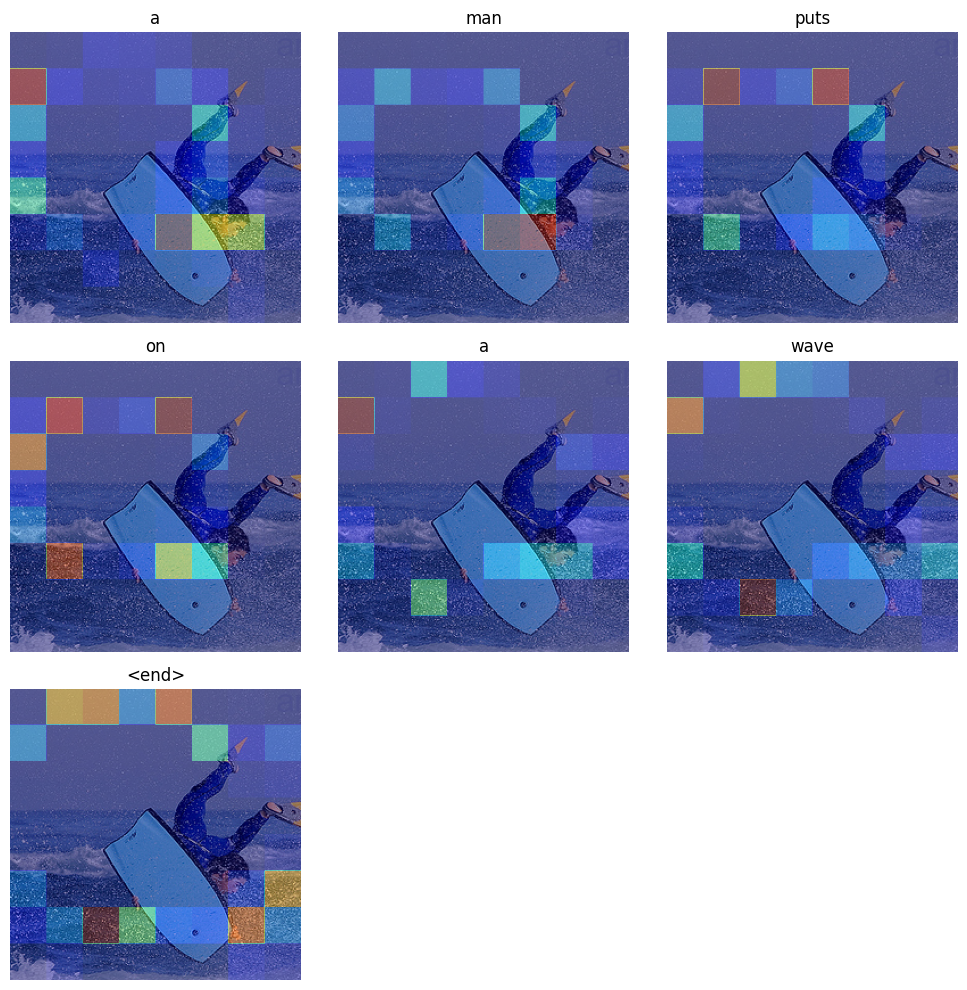

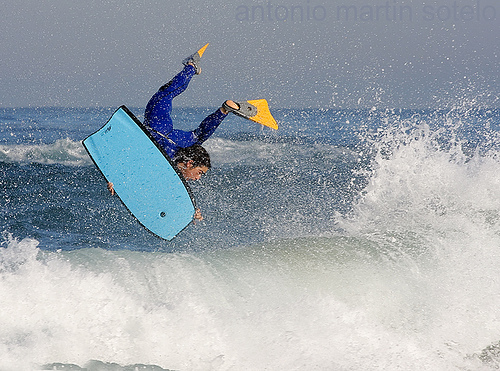

In [26]:
import matplotlib.pyplot as plt
max_length = 39
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
# image = "image.jpg"
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print("Ground truth caption: ", real_caption)
print("Generated caption: ", ' '.join(result))
plot_attention(image, result, attention_plot)

# Image.open(img_name_val[rid])
Image.open(image)

In [29]:
#TRYING BLEU SCORES
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import nltk
nltk.download('punkt')

def calculate_bleu_scores(encoder, decoder, test_images, img_to_cap_vector, tokenizer, max_length=40):
    all_references = []
    all_hypotheses = []
    smoothing = SmoothingFunction().method1
    
    for image_path in test_images:
        # Get all reference captions for this image (exclude padding)
        references = [
            [tokenizer.index_word[i] for i in cap if i not in [0]] 
            for cap in img_to_cap_vector[image_path]
        ]
        all_references.append(references)
        
        # Generate prediction
        result, _ = evaluate(image_path)  # Use your existing evaluate function
        all_hypotheses.append(result)
    
    return {
        'BLEU-1': corpus_bleu(all_references, all_hypotheses, weights=(1, 0, 0, 0), smoothing_function=smoothing),
        'BLEU-2': corpus_bleu(all_references, all_hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing),
        'BLEU-3': corpus_bleu(all_references, all_hypotheses, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing),
        'BLEU-4': corpus_bleu(all_references, all_hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)
    }

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [30]:
bleu_scores = calculate_bleu_scores(
    encoder=encoder,
    decoder=decoder,
    test_images=img_name_val[:100],
    img_to_cap_vector=img_to_cap_vector,
    tokenizer=tokenizer
)

print("\n=== Final Evaluation ===")
for name, score in bleu_scores.items():
    print(f"{name}: {score:.4f}")


=== Final Evaluation ===
BLEU-1: 0.5688
BLEU-2: 0.3675
BLEU-3: 0.2283
BLEU-4: 0.1303


In [38]:
#TTS MODULE
from google.cloud import texttospeech
from google.oauth2 import service_account

CREDENTIALS_PATH = "credentials.json"  # Use forward slashes
credentials = service_account.Credentials.from_service_account_file(
    CREDENTIALS_PATH,
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)
client = texttospeech.TextToSpeechClient(credentials=credentials)

def text_to_speech(text, output_file="output.mp3", voice_name="en-IN-Standard-C"):
    client = texttospeech.TextToSpeechClient(credentials = credentials)
    synthesis_input = texttospeech.SynthesisInput(text=text)

    voice = texttospeech.VoiceSelectionParams(
        language_code="en-IN",
        name=voice_name,
        ssml_gender=texttospeech.SsmlVoiceGender.MALE
    )

    audio_config = texttospeech.AudioConfig(
        audio_encoding=texttospeech.AudioEncoding.MP3
    )

    response = client.synthesize_speech(
        input=synthesis_input,
        voice=voice,
        audio_config=audio_config
    )

    with open(output_file, "wb") as out:
        out.write(response.audio_content)
    print(f"Audio saved to {output_file}")

# Usage
text_to_speech(' '.join(result))

Audio saved to output.mp3
